In [0]:
!pip install pennylane pennylane-sf pennylane-qiskit pennylane-cirq pennylane-forest pennylane-qsharp

In [0]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, NesterovMomentumOptimizer

In [0]:
# vamos a usar el simulador de superconductores
dev = qml.device("default.qubit", wires=1)

In [0]:
# def get_angles(x):

#     beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
#     beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
#     beta2 = 2 * np.arcsin(
#         np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
#     )

#     return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a, wires=0)

    #qml.CNOT(wires=[0, 1])

    qml.PauliX(wires=0)
  

In [0]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    #qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    #qml.CNOT(wires=[0, 1])

In [0]:
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [0]:
def matrix_learner(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias

In [0]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [0]:
def cost(weights, features, labels):
    predictions = [matrix_learner(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

In [0]:
# meto array y quiero que mi circuito aprenda la matriz que multiplicado por X da Y
X = np.array([0, 3])
Y = np.array([1, 3])

In [0]:
# var sera la matriz de weights que debera aprender el circuito; la inicializamos con pesos aleatorios
np.random.seed(0)
num_qubits = 1
num_layers = 1
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

print(var_init)

(array([[[0.01764052, 0.00400157, 0.00978738]]]), 0.0)


In [0]:
opt_GDO = qml.GradientDescentOptimizer(0.01)
opt_ADAM = qml.NesterovMomentumOptimizer(0.01)
opt_ADAGRAD = qml.AdamOptimizer(0.01)

var_GDO = var_init
var_ADAM = var_init
var_ADAGRAD = var_init

optimizers = [opt_GDO, opt_ADAM, opt_ADAGRAD]
vars = [var_GDO, var_ADAM, var_ADAGRAD]
name = ['Gradient Descent', 'Nesterov', 'Adam']
cost_func = np.zeros((1000, 3))
# ahora iteramos sobre los tres optimizadores
i = 0
while i < 3:
  opt = optimizers[i]
  for it in range(1000):
      vars[i] = opt.step(lambda v: cost(v, X, Y), vars[i])
      cost_func[it][i] = cost(vars[i], X, Y)
      print("Iter: {:5d} | Cost: {:0.7f} | {}".format(it + 1, cost(vars[i], X, Y), name[i]))
  i += 1

Iter:     1 | Cost: 3.8611732 | Gradient Descent
Iter:     2 | Cost: 3.7075145 | Gradient Descent
Iter:     3 | Cost: 3.5599708 | Gradient Descent
Iter:     4 | Cost: 3.4182986 | Gradient Descent
Iter:     5 | Cost: 3.2822643 | Gradient Descent
Iter:     6 | Cost: 3.1516435 | Gradient Descent
Iter:     7 | Cost: 3.0262209 | Gradient Descent
Iter:     8 | Cost: 2.9057895 | Gradient Descent
Iter:     9 | Cost: 2.7901507 | Gradient Descent
Iter:    10 | Cost: 2.6791138 | Gradient Descent
Iter:    11 | Cost: 2.5724958 | Gradient Descent
Iter:    12 | Cost: 2.4701206 | Gradient Descent
Iter:    13 | Cost: 2.3718196 | Gradient Descent
Iter:    14 | Cost: 2.2774306 | Gradient Descent
Iter:    15 | Cost: 2.1867978 | Gradient Descent
Iter:    16 | Cost: 2.0997718 | Gradient Descent
Iter:    17 | Cost: 2.0162092 | Gradient Descent
Iter:    18 | Cost: 1.9359720 | Gradient Descent
Iter:    19 | Cost: 1.8589279 | Gradient Descent
Iter:    20 | Cost: 1.7849499 | Gradient Descent
Iter:    21 | Cost: 

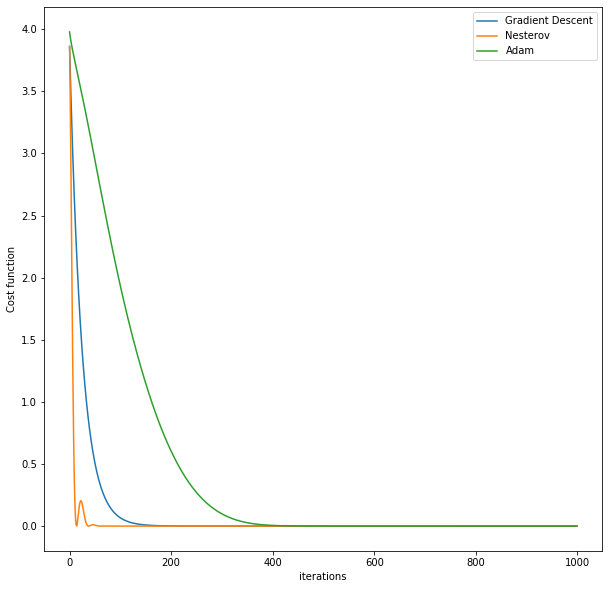

In [0]:
# aca graficamos la evolucion de los optimizadores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(cost_func[:,0])
plt.plot(cost_func[:,1])
plt.plot(cost_func[:,2])

plt.xlabel('iterations')
plt.ylabel('Cost function')
plt.legend(['Gradient Descent', 'Nesterov', 'Adam'])
plt.show()

In [0]:
x_pred = [0, 3]
predictions = []
predictions.append([matrix_learner(vars[0], angles = x_) for x_ in x_pred])
predictions.append([matrix_learner(vars[1], angles = x_) for x_ in x_pred])
predictions.append([matrix_learner(vars[2], angles = x_) for x_ in x_pred])

In [0]:
print('Usando Gradient Descent.', 'Predicciones:',predictions[0], '; M:', vars[0])
print('Usando Nesterov.', 'Predicciones:', predictions[1], '; M:', vars[1])
print('Usando Adam.', 'Predicciones:', predictions[2], '; M:', vars[2])

Usando Gradient Descent. Predicciones: [1.004353717253062, 2.9956085022803176] ; M: [array([[[ 0.0174643 , -0.13197554,  0.00978738]]]), 1.995657578246464]
Usando Nesterov. Predicciones: [1.00302288106387, 2.996963284510042] ; M: [array([[[ 0.01762736, -0.10320054,  0.00978738]]]), 1.9977024296557582]
Usando Adam. Predicciones: [1.0025000443953203, 2.9974862037294177] ; M: [array([[[ 7.38521744e-15, -7.27516920e-02,  9.78737984e-03]]]), 1.999854807088709]
